# Deux conteneurs
## filebench : filemicro_seqread vs filemicro_randread
### Tester la soft limite
#### Description
Le but de cette expérience est de simuler le gain obtenu si la `soft` limite d'une conteneur ayant de bonnes performances était diminuée pour essayer d'augmenter les performances de l'autre conteneur.

On se place dans un scénario où deux conteneurs (A et B) exécutant des charges de travail différentes (`filemicro_seqread` avec un fichier de 2GB et `filemicro_randread` avec un fichier de 1 GB) sont lancés. Les conteneurs s'exécutent par contre **60 secondes**.

Initialement, le conteneur A verra sa `soft` limite fixée à 2.7GB et le conteneur B à 300MB. La limite du conteneur A sera ensuite diminuée 3 fois par pas de 200MB et celle du conteneur B augmentée de la même manière.

#### Environnement 
Les conteneurs ont été lancés dans une machine virtuelle linux 4.19.5 disposant de 3GB de mémoire et 2 coeurs.

Les accès au disque de la machine virtuelle ne pouvaient pas compter sur le cache fichier du système hôte car celui-ci a été désactivé.

Chaque conteneur est lancé avec une `max` limite fixée à 3GB. Les différentes exécutions n'ont pas d'impact les unes sur les autres car le cache fichier est vidé entre chaque itération.

Les différentes charges de travail sont exécutées dans `/tmp` qui appartient à un volume ayant pour système de fichier `ext4fs`.


#### Résultats attendus
D'après les expériences précédentes nous savons que le conteneur A s'exécute idéalement avec 2.3GB de mémoire par conséquent tant que sa mémoire sera supérieur à cette valeur il présentera de bonnes performances.

Le conteneur B verra ses performances s'améliorer au fur et à mesure que sa mémoire sera agrandie.

#### Algorithme de l'expérience
Les expériences ont été répétées 10 fois afin de calculer une moyenne et l'écart-type associé.

Le script permettant de lancer plusieurs conteneurs en même temps et d'obtenir des statistiques sur ceux-ci est le suivant (une version ne lançant qu'un conteneur a aussi été écrite) :
```python
#! /usr/bin/env python3
# SPDX-License-Identifier: MPL-2.0
import sys
import docker
import os
import threading
import json

"""This python script will start two containers with filebench with the given as
argument soft limits.

It will then run 10 times the FILEBENCH_CONTAINER_A and FILEBENCH_CONTAINER_B in
each container as argument. The output of filebench will be written to a file
and statistics (memory usage in bytes and reads from the disk) will be written
to another file.
"""

# Filebench command for the container A, B and C.
FILEBENCH_CONTAINER_COMMANDS = ['./filebench -f workloads/filemicro_seqread.f', './filebench -f workloads/filemicro_randread_1G.f']

CHARS = ['A', 'B']

# Each run lasts 60 seconds.
FILEBENCH_DURATION = 60

def thread_func(container, command, out, stats):
	"""Run the command in container and write the output in out.
	This function will be used as a thread.
	:param container: The container in which command will be run. It must already
	been started.
	:type container: docker.models.containers.Container
	:param command: The command to run in container.
	:type command: str
	:param out: An open in write file object where the output of command will be
	written.
	:type out: _io.TextIOWrapper
	:param out: An open in write file object where the stats of the container will
	be written.
	:type out: _io.TextIOWrapper
	"""
	gen = container.stats()

	# Run the benchmark inside the container and write the output to out.
	# exec_run returns a tuple whom second field contains bytes. The decode
	# translate them to a string.
	out.write(container.exec_run(command)[1].decode('utf-8') + '\n')

	statistics = []
	old_read = 0

	for record in gen:
		# Translate the record in string and translate it to python dictionary.
		# Vive la Joz' ! Bon vivant Docteur bon vivant !
		jason = json.loads(record.decode('utf-8'))

		# Create a new dictionary at each iteration so the statistics's cases are
		# differents.
		chicandier = {'usage': jason['memory_stats']['usage']}

		for io in jason['blkio_stats']['io_serviced_recursive']:
			if io['op'] == 'Read':
				# Get the difference between this iteration and the previous one.
				# The value is so the number of read for this second. It can be seen
				# as the bandwith.
				val = io['value'] - old_read

				# Update the old value. Since it begins at 0 the first value will be
				# quite wrong but I do not think it will be a big problem.
				old_read = io['value']

				# Little trick if the key is not already present.
				if 'reads' in chicandier:
					chicandier['reads'] += val
				else:
					chicandier['reads'] = val

		statistics.append(chicandier)

		# Our filebenches last FILEBENCH_DURATION seconds so we just want
		# FILEBENCH_DURATION records since containerd give stats every second.
		if len(statistics) == FILEBENCH_DURATION:
			break

	# Add the statistics to the stat file.
	for i in range(len(statistics)):
		stats.write('%d;%d;%d\n' % (i, statistics[i]['usage'], statistics[i]['reads']))

def main():
	containers = []
	outs = []
	stats = []

	if len(sys.argv) != 3:
		sys.exit("Usage: %s soft_limit0 soft_limit1" % sys.argv[0])

	client = docker.from_env()

	# sys.argv[1:] because sys.argv[0] is the program name.
	for soft_limit in sys.argv[1:]:
		# Launch containers as detached, set their max limits to 3G, their soft
		# limits to given arguments.
		containers.append(client.containers.run('filebench', auto_remove = True, detach = True, mem_limit = '3G', mem_reservation = soft_limit))

	# Open /proc/sys/vm/drop_caches to be able to drop linux page cache.
	drop_cache = open('/proc/sys/vm/drop_caches', 'wb', buffering = 0)

	# Run each benchmark once so their files will be prepared for the next times
	# and they will begin to read files approximately at the same time.
	for i in range(len(containers)):
		containers[i].exec_run(FILEBENCH_CONTAINER_COMMANDS[i])

		# Drop the cache so the run above does not have a consequence on the runs
		# below. It can be a good idea to separate our filebench experiment in two
		# WSL files: one for preparing the run (by creating file) and the other to
		# effectively run the benchmark.
		drop_cache.write(bytearray('3\n', 'utf-8'))

		# sys.argv[i + 1] because sys.argv[0] is the program name and there are
		# len(sys.argv) - 1 containers.
		outs.append(open(os.path.expanduser('~/container_%c_%s_%s.out' % (CHARS[i], containers[i].name, sys.argv[i + 1])), 'w'))
		stats.append(open(os.path.expanduser('~/container_%c_%s_%s.stats' % (CHARS[i], containers[i].name, sys.argv[i + 1])), 'w'))

		stats[i].write('iteration;usage;reads\n')

	# Run each filebench 10 times to compute mean and standard deviation.
	for i in range(10):
		threads = []

		for j in range(len(containers)):
		# Prepare the threads which will run filebench inside the containers.
			threads.append(threading.Thread(target = thread_func, args = (containers[j], FILEBENCH_CONTAINER_COMMANDS[j], outs[j], stats[j])))

		# Launch the threads.
		for t in threads:
			t.start()

		# Wait them.
		for t in threads:
			t.join()

		# Drop the cache between each run so they are independents.
		drop_cache.write(bytearray('3\n', 'utf-8'))

	# Stop and close everything.
	for i in range(len(containers)):
		containers[i].stop()

		outs[i].close()
		stats[i].close()

	drop_cache.close()

if __name__ == "__main__":
    main()
```

Ce script est une amélioration et généralisation du script utilisé précédemment pour lancer 2 conteneurs.

Ces scripts ont ensuite été exécutés depuis un script bash qui gère les différentes configuration de `soft` limite qui ont été listées dans la description :
```bash
#! /usr/bin/env bash
# SPDX-License-Identifier: MPL-2.0
# Copyright (c) 2019 Francis Laniel <francis.laniel@lip6.fr>

python3 extended_test_soft_limit.py 2700M 300M
echo 'Finished run 2.7G/.3G!'
python3 extended_test_soft_limit.py 2500M 500M
echo 'Finished run 2.5G/.5G!'
python3 extended_test_soft_limit.py 2300M 700M
echo 'Finished run 2.3G/.7G!'
python3 extended_test_soft_limit.py 2100M 900M
echo 'Finished run 2.1G/.9G!'
```

#### Résultats obtenus
Le comportement des charges de travail `filemicro_seqread` et `filemicro_randread` étant connus ceux-ci ne seront pas exécutés seul.

Les deux conteneurs sont lancés ensemble et exécutent leurs charges de travail ensemble. Les résultats obtenus sont les suivants :

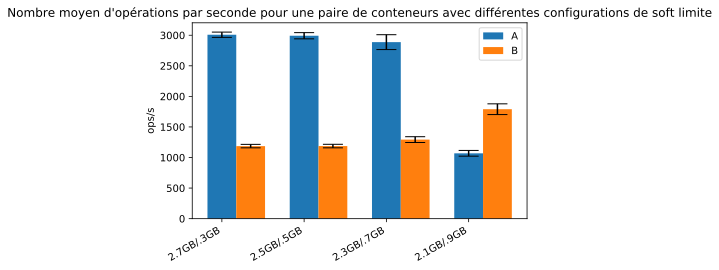

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

DIR = 'pair'
# Since there is sometimes two files with the same size for container A there was a risk of 
# confusion.
# But the timestamp of container_b files can help to guess the correct one.
A_FILES = ['%s/container_A_thirsty_archimedes_2700M.out.csv' % DIR, '%s/container_A_elated_antonelli_2500M.out.csv' % DIR, '%s/container_A_modest_leavitt_2300M.out.csv' % DIR, '%s/container_A_admiring_mccarthy_2100M.out.csv' % DIR]
B_FILES = ['%s/container_B_romantic_curie_300M.out.csv' % DIR, '%s/container_B_tender_stonebraker_500M.out.csv' % DIR, '%s/container_B_clever_burnell_700M.out.csv' % DIR, '%s/container_B_gracious_williamson_900M.out.csv' % DIR]

# lists for the bar chart (A is first container, B is second (see above)).
A_means = []
A_stds = []

B_means = []
B_stds = []

for file in A_FILES:
    # Get data from CSV file.
    df = pd.read_csv(file, ';')
    values = df.values

    # Computing mean and standard deviation.
    # values is a numpy.ndarray i.e an array of tuples.
    # mean() and std() take an axis as argument and return a tuple.
    # [1] permits to obtain second member of tuple.
    A_means.append(values.mean(0)[1])
    A_stds.append(values.std(0)[1])

for file in B_FILES:
    df = pd.read_csv(file, ';')
    values = df.values

    B_means.append(values.mean(0)[1])
    B_stds.append(values.std(0)[1])

# xtick labels for the bar chart.
names = ['2.7GB/.3GB', '2.5GB/.5GB', '2.3GB/.7GB', '2.1GB/.9GB']
x_pos = np.arange(len(names))

# Axis and figure initialization.
fig, ax = plt.subplots()
# The width of the bars.
WIDTH = .35
group0 = ax.bar(x_pos, A_means, WIDTH, yerr = A_stds, align = 'center', capsize = 10)
# Shift the position the second bar by width.
group1 = ax.bar(x_pos + WIDTH, B_means, WIDTH, yerr = B_stds, align = 'center', capsize = 10)
ax.set_ylabel('ops/s')
ax.set_xticks(x_pos)
ax.set_xticklabels(names)
ax.legend((group0[0], group1[0]), ('A', 'B'))
ax.set_title("Nombre moyen d'opérations par seconde pour une paire de conteneurs avec différentes configurations de soft limite")

fig.autofmt_xdate()
# Print the figure.
set_matplotlib_formats('svg')
plt.show()

On peut voir que les performances du conteneur A se dégrade peu quand sa `soft` limite diminue sauf lorsque celle-ci vaut 2.1GB.

Le conteneur B voit ses performances légèrement augmentées dans les trois premiers cas (passant de moins de 1200 ops/s à un peu moins de 1300 ops/s). Dans le dernier cas ses performances sont encore meilleures mais n'atteignent pas 4000 ops/s.

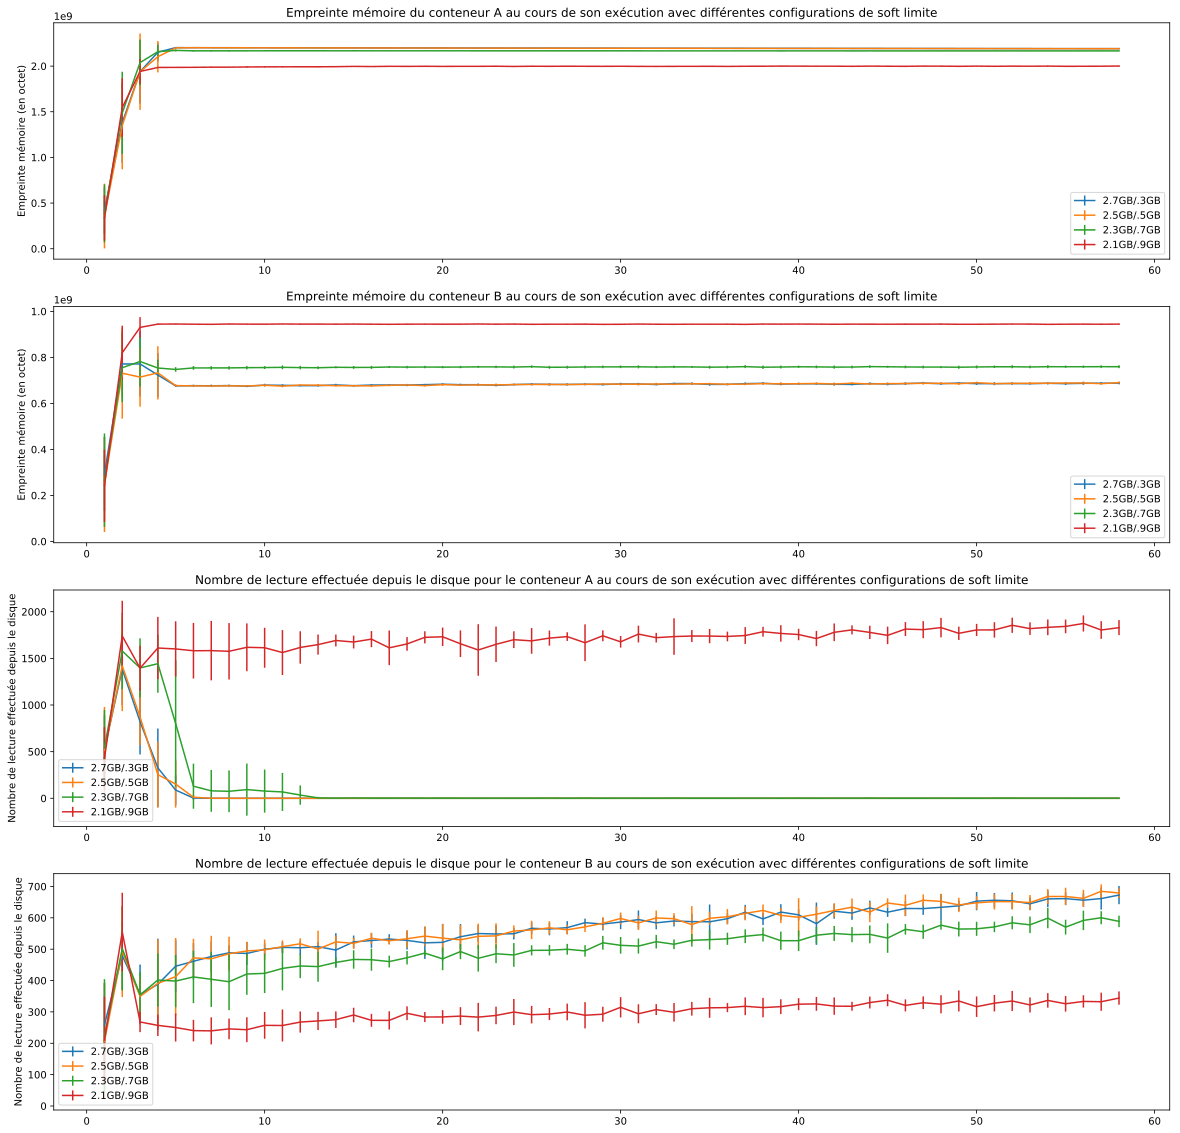

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

LABELS = ['2.7GB/.3GB', '2.5GB/.5GB', '2.3GB/.7GB', '2.1GB/.9GB']

DIR = 'pair'
# Since there is two *_1G files for container A there was a risk of confusion.
# But the timestamp of container_b files can help to guess the correct one.
A_FILES = ['%s/container_A_thirsty_archimedes_2700M.stats.csv' % DIR, '%s/container_A_elated_antonelli_2500M.stats.csv' % DIR, '%s/container_A_modest_leavitt_2300M.stats.csv' % DIR, '%s/container_A_admiring_mccarthy_2100M.stats.csv' % DIR]
B_FILES = ['%s/container_B_romantic_curie_300M.stats.csv' % DIR, '%s/container_B_tender_stonebraker_500M.stats.csv' % DIR, '%s/container_B_clever_burnell_700M.stats.csv' % DIR, '%s/container_B_gracious_williamson_900M.stats.csv' % DIR]
# Dictionaries initialization.
A_dict = {'usage': {'means': [], 'stds': []}, 'reads': {'means': [], 'stds': []}}
B_dict = {'usage': {'means': [], 'stds': []}, 'reads': {'means': [], 'stds': []}}

for file in A_FILES:
    df = pd.read_csv(file, ';')
    values = df.values
    
    # The first record has strange standard deviation values so we do not get it.
    A_dict['usage']['means'].append(values.take(1, axis = 1)[1 : len(values) - 1])
    A_dict['usage']['stds'].append(values.take(2, axis = 1)[1 : len(values) - 1])
    
    A_dict['reads']['means'].append(values.take(3, axis = 1)[1 : len(values) - 1])
    A_dict['reads']['stds'].append(values.take(4, axis = 1)[1 : len(values) - 1])

for file in B_FILES:
    df = pd.read_csv(file, ';')
    values = df.values
    
    # The first record has strange standard deviation values so we do not get it.
    B_dict['usage']['means'].append(values.take(1, axis = 1)[1 : len(values) - 1])
    B_dict['usage']['stds'].append(values.take(2, axis = 1)[1 : len(values) - 1])
    
    B_dict['reads']['means'].append(values.take(3, axis = 1)[1 : len(values) - 1])
    B_dict['reads']['stds'].append(values.take(4, axis = 1)[1 : len(values) - 1])

# xtick labels for the bar chart.
x_pos = np.arange(len(range(60)))

# Axis and figure initialization. We need four axis:
# 1. Memory usage of container A.
# 2. Memory usage of container B.
# 3. Reads from disk of container A.
# 4. Reads from disk of container B.
fig, (A_usage_ax, B_usage_ax, A_reads_ax, B_reads_ax) = plt.subplots(nrows = 4, figsize = (20, 20))

for i in range(len(LABELS)):
    A_usage_ax.errorbar(x_pos[1 : len(x_pos) - 1], A_dict['usage']['means'][i], yerr = A_dict['usage']['stds'][i], label = LABELS[i])
    A_reads_ax.errorbar(x_pos[1 : len(x_pos) - 1], A_dict['reads']['means'][i], yerr = A_dict['reads']['stds'][i], label = LABELS[i])
    
    B_usage_ax.errorbar(x_pos[1 : len(x_pos) - 1], B_dict['usage']['means'][i], yerr = B_dict['usage']['stds'][i], label = LABELS[i])
    B_reads_ax.errorbar(x_pos[1 : len(x_pos) - 1], B_dict['reads']['means'][i], yerr = B_dict['reads']['stds'][i], label = LABELS[i])
    
A_usage_ax.legend()
A_usage_ax.set_ylabel('Empreinte mémoire (en octet)')
A_usage_ax.set_title('Empreinte mémoire du conteneur A au cours de son exécution avec différentes configurations de soft limite')

A_reads_ax.legend()
A_reads_ax.set_ylabel('Nombre de lecture effectuée depuis le disque')
A_reads_ax.set_title('Nombre de lecture effectuée depuis le disque pour le conteneur A au cours de son exécution avec différentes configurations de soft limite')

B_usage_ax.legend()
B_usage_ax.set_ylabel('Empreinte mémoire (en octet)')
B_usage_ax.set_title('Empreinte mémoire du conteneur B au cours de son exécution avec différentes configurations de soft limite')

B_reads_ax.legend()
B_reads_ax.set_ylabel('Nombre de lecture effectuée depuis le disque')
B_reads_ax.set_title('Nombre de lecture effectuée depuis le disque pour le conteneur B au cours de son exécution avec différentes configurations de soft limite')

# Print the figure.
set_matplotlib_formats('svg')
plt.show()

La légère chute de performance du conteneur A peut s'expliquer par le fait qu'il fait plus longtemps des lectures depuis le disque (pendant 5 secondes dans les deux premiers cas et pendant 10 seconde pour le troisième). 

Sa chute de performance dans le dernier cas s'explique par le fait qu'il fait tout au long de son exécution des lectures depuis le disque car son empreinte mémoire est trop petite.

À l'inverse, le conteneur B voit ses performances s'améliorer car il effectue moins de lecture depuis le disque (environ 500 dans les deux premiers cas puis 400 dans le troisème cas et 200 dans le dernier à la dixième seconde d'exécution) car son empreinte mémoire grandit.

On peut aussi remarquer le fait que le nombre de lecture du conteneur B augmente légèrement au cours du temps.

#### Conclusion
D'une manière globale le dernier cas n'est pas un cas souhaitable à atteindre car aucune des applications ne s'exécutent bien.

Il peut par contre être intéressant de passer du premier au deuxième cas voir du premier au troisième. Car dans ces cas le conteneur A s'exécute toujours bien et le surplus de mémoire du conteneur B lui permet d'améliorer légèrement ses performances.